# AME Dataset Investigation
Author: Raphael Pereira Rolim e Silva

> Here, I try to see how to fit AME dataset in my Neural Network project.

## Dependencies and functions

In [3]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Input
# from sklearn.model_selection import train_test_split
#############################################
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
###############################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data as hdata
import beam_modelling as model

In [58]:
def smooth_map(healpix_map, nbands=30, nu_min=980, nu_max=1260, D=40, in_degree=True, type_='gaussian'):
    """
    Process a HEALPix map by adjusting frequency bands, calculating beam window function,
    and smoothing the map.
    The values of this function are adjusted for the BINGO radio-telescope.

    Parameters:
    - healpix_map: array-like
        The HEALPix map data.
    - nbands: int
        Number of frequency bands.
    - nu_min: float
        Minimum frequency of observation.
    - nu_max: float
        Maximum frequency of observation.
    - D: float
        Diameter for the dish.
    - in_degree: bool
        Whether to use degrees in the beam window function.
    - type_: str
        The type of the beam window function.

    Returns:
    - g_smoothed_map: array-like
        The smoothed HEALPix map.
    """
    # Adjusting nu
    nu_step = (nu_max - nu_min) / nbands
    nu = np.around(np.arange(nu_min, nu_max, nu_step), decimals=2)

    # Adjusting ell
    nside = hp.get_nside(healpix_map)
    lmax = 3 * nside
    l = np.arange(lmax + 1)

    # FWHM (Delta theta_r)
    fwhm = model.fwhm_modelling(nu=nu[0], type_='smooth', D=D, in_degree=in_degree)

    # Adjusting theta
    theta = np.arange(0, 10, 0.01)

    # Get beam window function
    bl = model.bl_function(type_=type_, fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

    # Visualize results
    smoothed_map = hp.smoothing(healpix_map, beam_window=bl)

    return smoothed_map

def healpix_to_array(data, dec_range, ra_range):
    """
    Returns a 2D projection of an FITS file in (num_bands, height, width).

    Parameters:
    - data: FITS file, HEALPix map
        Desired data already opened.
    - dec_range: array-like
        Range of declination in degrees where dec_range[0] is the minimum and dec_range[1] is the maximum.
    - ra_range: array-like
        Range of right ascension in degrees where ra_range[0] is the minimum and ra_range[1] is the maximum.

    Returns:
    - projection: array-like
        2D projection of the FITS file in (num_bands, height, width).
    """
    if data.ndim > 1:
        nside = hp.get_nside(data[0])
        num_bands = data.shape[0]
    else:
        nside = hp.get_nside(data)
        num_bands = 1

    # Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
    theta_range = np.radians([90 - dec_range[1], 90 - dec_range[0]])
    phi_range = np.radians([ra_range[0], ra_range[1]])

    # Calculate the resolution of the HEALPix map in radians
    resolution = np.sqrt(hp.nside2pixarea(nside))

    # Calculate width and height based on the resolution and the specified ranges
    width = int(np.abs(phi_range[1] - phi_range[0]) / resolution)
    height = int(np.abs(theta_range[1] - theta_range[0]) / resolution)

    # Create an array for the 2D projection
    projection = np.zeros((num_bands, height, width))

    # Set up the grid for theta and phi
    theta = np.linspace(theta_range[0], theta_range[1], height)
    phi = np.linspace(phi_range[0], phi_range[1], width)
    phi, theta = np.meshgrid(phi, theta)

    # Convert theta, phi to HEALPix pixel indices
    pix_indices = hp.ang2pix(nside, theta, phi)

    if data.ndim > 1:
        for band in range(num_bands):
            projection[band, :, :] = data[band][pix_indices]  # Map HEALPix data to 2D grid
    else:
        projection[:, :] = data[pix_indices]

    return projection
    
from scipy.interpolate import griddata
def healpix_to_squares(data, target_nside):
    if data.ndim > 1:
        nside = hp.get_nside(data[0])
        num_bands = data.shape[0]
    else:
        nside = hp.get_nside(data)
        num_bands = 1
    
    npix = hp.nside2npix(nside)
    nside_ratio = nside // target_nside
    
    # Determine the resolution of the new grid
    n_pixels_side = 2 * nside  # Approximation for the 2D grid side length
    
    # Convert HEALPix indices to theta, phi coordinates
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    
    # Convert theta, phi to x, y coordinates
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    
    # Create a grid for interpolation
    xi = np.linspace(x.min(), x.max(), n_pixels_side)
    yi = np.linspace(y.min(), y.max(), n_pixels_side)
    xi, yi = np.meshgrid(xi, yi)
    
    squares = []
    
    for band in range(num_bands):
        if num_bands > 1:
            healpix_map = data[band]
        else:
            healpix_map = data
        
        # Interpolate the map data to the new grid
        interpolated_map = griddata((x, y), healpix_map, (xi, yi), method='linear', fill_value=0)
        
        # Reshape the interpolated map into squares
        band_squares = []
        step = n_pixels_side // nside_ratio
        for i in range(0, n_pixels_side, step):
            for j in range(0, n_pixels_side, step):
                square = interpolated_map[i:i+step, j:j+step]
                band_squares.append(square)
        
        squares.append(np.array(band_squares))
    
    squares = np.array(squares)
    
    if num_bands == 1:
        squares = squares[0]
        
    return squares

## Visualize data

In [5]:
path_AME = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256/'
filename = 'FG_I_256_980mhz1260mhz_37bins_full_AME_L0.fits'
data = hdata.getmap(dirpath_=path_AME, filename_=filename, healpix_readingformat=False, hdu=1)

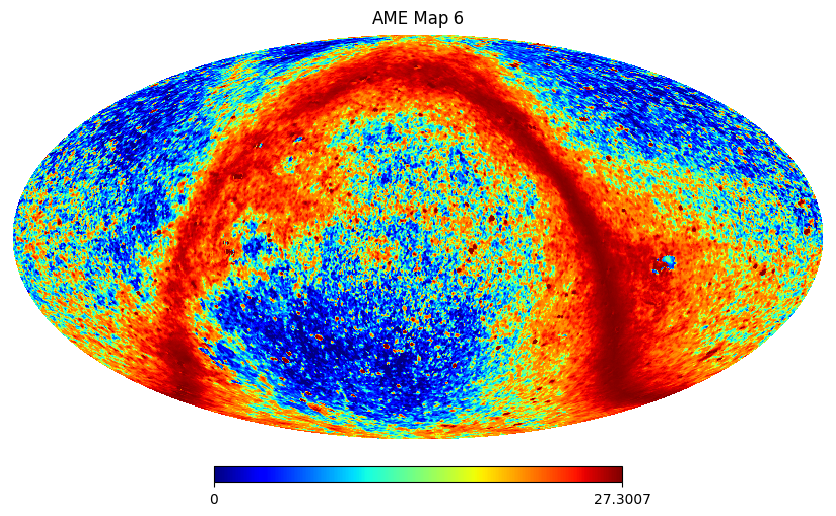

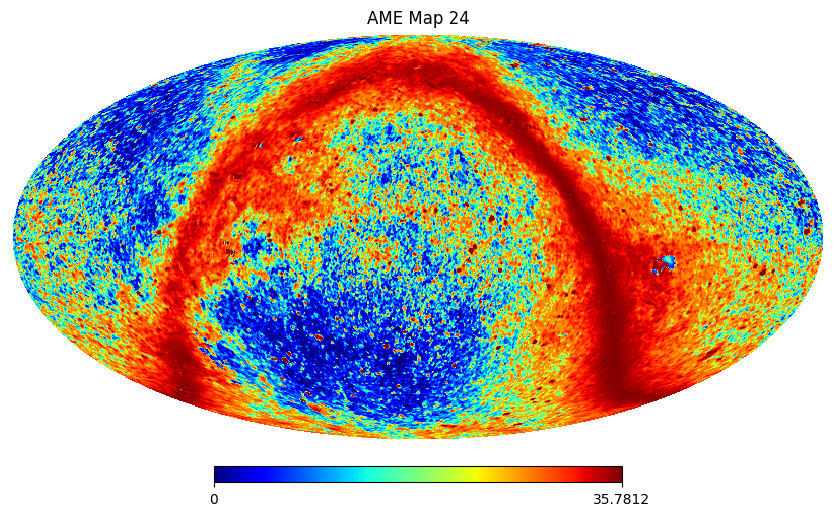

In [62]:
# Visualize
i1 = np.random.randint(0,20)
hp.mollview(data[i1], cmap='jet', norm='hist', title=f'AME Map {i1}')

#plt.savefig(f'AME_cartview_map_{i1}.png', bbox_inches='tight', dpi=240)

i2 = np.random.randint(20,37)
hp.mollview(data[i2], cmap='jet', norm='hist', title=f'AME Map {i2}')

## Map Convolution

In [69]:
from scipy.ndimage import rotate
def plot_projection_info(ax, projection, title, bins):
    """
    Plot projection information including shape and histogram.

    Parameters:
    ax (matplotlib.axes.Axes): Axes object to plot on.
    projection (numpy.ndarray): 2D array representing the projection.
    title (str): Title for the plot.
    """
    # Compute the histogram of the data
    hist, bins = np.histogram(projection.flatten(), bins=bins, density=True)

    # Normalize the histogram manually
    hist /= hist.sum()

    # Display the projected map
    im = ax.imshow(rotate(projection[0], 180, reshape=False), origin='lower', aspect='auto', norm=plt.Normalize(hist.min(), hist.max()), cmap='jet')
    ax.set_title(title)  # Set the title on the plot
    ax.axis('off')
    return im

In [19]:
# Config
dec = [-4,4]
ra = [-4,4]
width, height = 64, 64

i = np.random.randint(0,37)

In [20]:
# Gaussian beam maps
g_smoothed_map = smooth_map(data[i], type_='gaussian')

# Cosine beam maps
c_smoothed_map = smooth_map(data[i], type_='cosine')

# Jinc beam maps
j_smoothed_map = smooth_map(data[i], type_='jinc')

In [91]:
# Original projection
og_proj = healpix_to_array(data[i], dec, ra)

# Gaussian projection
g_proj = healpix_to_array(g_smoothed_map, dec, ra)

# Cosine projection
c_proj = healpix_to_array(c_smoothed_map, dec, ra)

# Jinc projection
j_proj = healpix_to_array(j_smoothed_map, dec, ra)

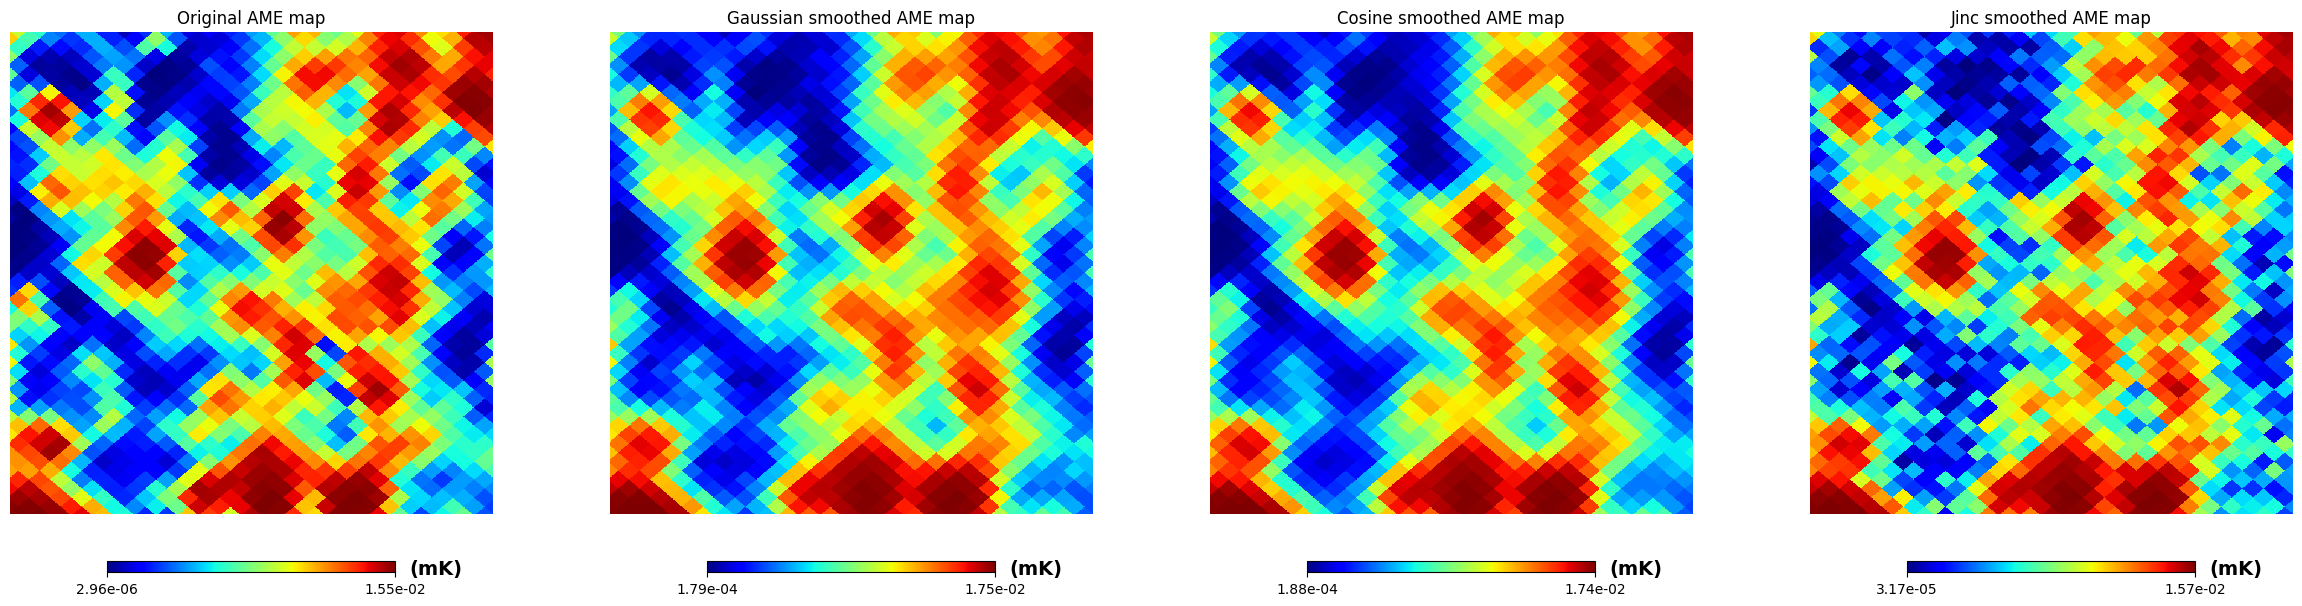

In [36]:
# Plot and compare
fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

smoothed_titles = [
    'Original AME map',
    'Gaussian smoothed AME map',
    'Cosine smoothed AME map',
    'Jinc smoothed AME map'
]

maps = [data[i], g_smoothed_map, c_smoothed_map, j_smoothed_map]

# Plot each map individually
hp.cartview(maps[0], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(maps[1], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(maps[2], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[2], fig=fig, sub=(1, 4, 3))
hp.cartview(maps[3], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[3], fig=fig, sub=(1, 4, 4))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('limited_cartview_maps.png', bbox_inches='tight')

plt.show()

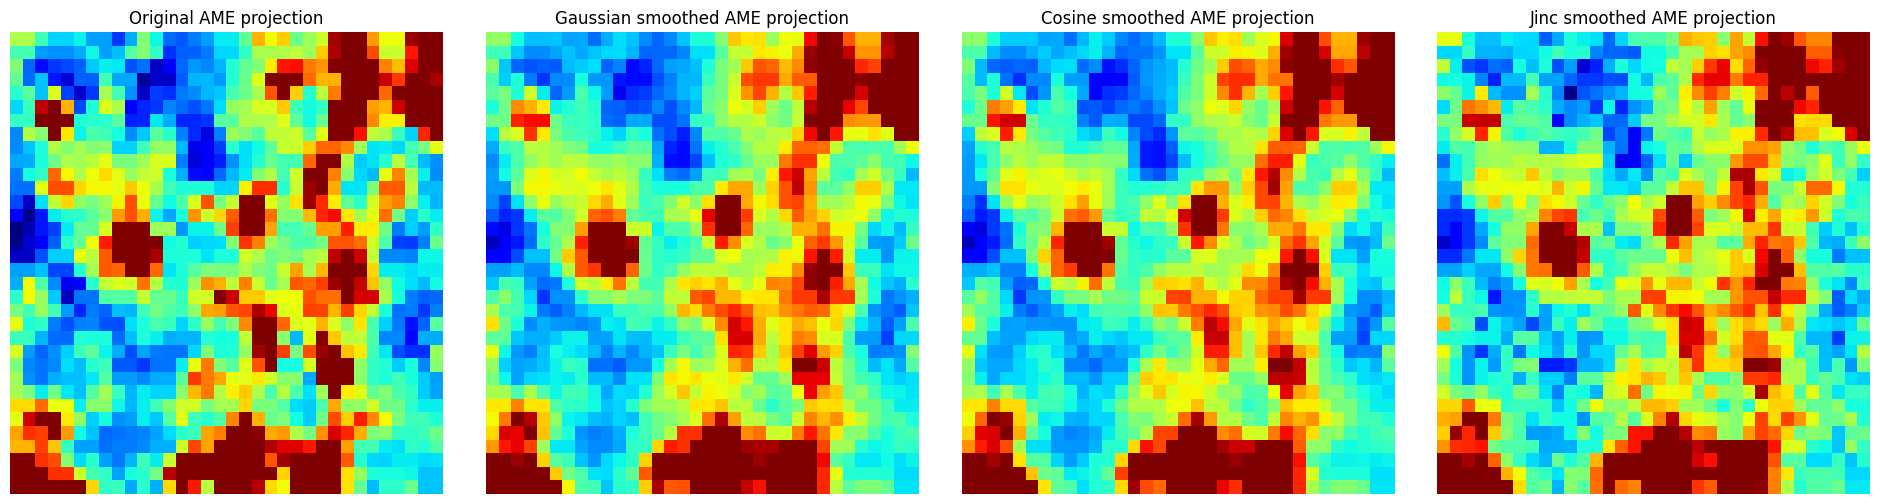

In [86]:
# Plot and compare
fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

titles = [
    'Original AME projection',
    'Gaussian smoothed AME projection',
    'Cosine smoothed AME projection',
    'Jinc smoothed AME projection'
]

projections = [og_proj, g_proj, c_proj, j_proj]

for ax, title, projection in zip(axes, titles, projections):
    plot_projection_info(ax, projection, title, bins=25000)

plt.show()

## Healpix to Array

In [43]:
# Auxiliary functions

def count_samples(data, dec_range, ra_range, step=4):
    bands = len(data)
    i = 0
    dec_values = np.arange(dec_range[0], dec_range[1], step)
    ra_values = np.arange(ra_range[0], ra_range[1], step)
    for ra_v in ra_values:
            for dec_v in dec_values:
                dec = [dec_v, dec_v+step]
                ra = [ra_v, ra_v+step]
                i += 1
    n_samples = bands * i
    return n_samples

def create_dataset(data, dec_range, ra_range, width, height, n_samples, step=4, type='gaussian', save=False, original=False, smoothed=True):
    og_projs = np.zeros((n_samples, 1, width, height))
    smoothed_projs = np.zeros((n_samples, 1, width, height))
    sample = 0
    print('Opening dataset...')
    for i in range(len(data)):
        # Set maps
        og_map = data[i]
        smoothed_map = smooth_map(og_map, type_=type)
    
        dec_values = np.arange(dec_range[0], dec_range[1], step)
        ra_values = np.arange(ra_range[0], ra_range[1], step)
    
        for ra_v in ra_values:
            for dec_v in dec_values:
                dec = [dec_v, dec_v+step]
                ra = [ra_v, ra_v+step]

                if original == True:
                    # Original maps
                    og_proj = healpix_to_array(og_map, width, height, dec, ra)
                    og_projs[sample] = og_proj
    
                if smoothed == True:
                    # Gaussian beam maps
                    smoothed_proj = healpix_to_array(smoothed_map, width, height, dec, ra)
                    smoothed_projs[sample] = smoothed_proj
    
                print(f'\rAppending sample {sample+1}/{n_samples} - Band {i+1} - DEC:{dec}, RA:{ra}         ', end='', flush=True)
                sample += 1
    
    print()
    print('Closing dataset...')
    
    if save == True:
        # Save maps
        if original == True:
            np.save(f'./og_maps.npy', og_projs)
        if smoothed == True:
            if type == 'gaussian':
                np.save(f'./g_smoothed_maps.npy', smoothed_projs)
            elif type == 'cosine':
                np.save(f'./c_smoothed_maps.npy', smoothed_projs)
            elif type == 'jinc':
                np.save(f'./j_smoothed_maps.npy', smoothed_projs)
        print('Dataset saved.')
    else:
        if original == True and smoothed == True:
            print('Dataset returned.')
            return og_projs, smoothed_projs
        elif original == False and smoothed == True:
            print('Dataset returned.')
            return smoothed_projs
        elif original == True and smoothed == False:
            print('Dataset returned.')
            return og_projs

In [39]:
# Config
width, height = 256, 256
dec_range = np.array([-20,20])
ra_range = np.array([-20,20])
n_samples = count_samples(data, dec_range, ra_range)

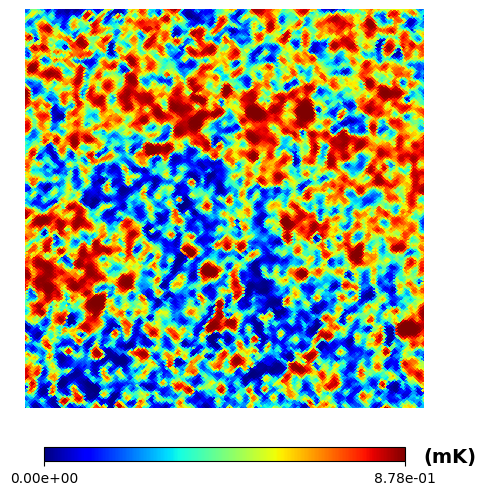

In [40]:
# Visualize range
hp.cartview(data[14], norm="hist", latra=[dec_range[0],dec_range[1]], lonra=[ra_range[0],ra_range[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title='')

#plt.savefig('limited_cartview_map_14.png', bbox_inches='tight', dpi=240)

plt.show()

In [12]:
# Create dataset
create_dataset(data, dec_range, ra_range, width, height, n_samples, original=True, save=True)

Opening dataset...
Appending sample 3700/3700 - Band 37 - DEC:[16, 20], RA:[16, 20]             
Closing dataset...
Dataset saved.


## HEALPix to Squares

In [96]:
def plot_squares(squares, num_samples=4):
    num_squares = squares.shape[0]
    
    # Ensure we don't select more samples than available squares
    num_samples = min(num_samples, num_squares)
    
    # Randomly select indices
    indices = np.random.choice(num_squares, num_samples, replace=False)
    
    # Create a subplot grid for the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))
    
    # Handle case when only one subplot is created
    if num_samples == 1:
        axes = [axes]
    
    # Plot the selected squares
    for i, idx in enumerate(indices):
        im = axes[i].imshow(squares[idx], origin='lower', norm='log', cmap='jet')
        plt.colorbar(im, ax=axes[i])
        axes[i].set_title(f'Sample {i+1}')
    
    plt.tight_layout()
    plt.show()

In [99]:
squares = healpix_to_squares(data[0], 256)

In [100]:
squares.shape

(1, 512, 512)

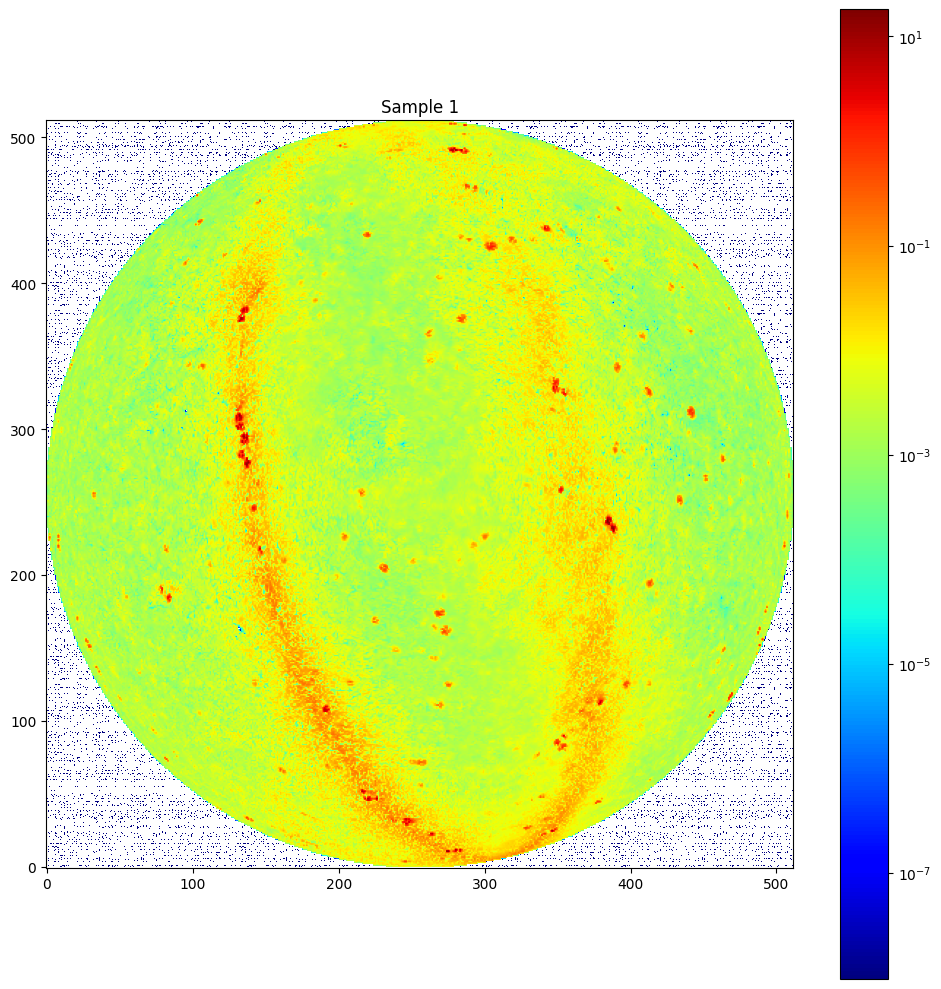

In [101]:
plot_squares(squares)

## Model creation

In [13]:
# Let's define the Peak to Signal Ratio metric
def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [14]:
# Load data
X = np.load('/media/BINGODATA1/BeamAnalysis/AME_dataset/g_smoothed_maps.npy', mmap_mode='r') # features (inputs)
y = np.load('/media/BINGODATA1/BeamAnalysis/AME_dataset/og_maps.npy', mmap_mode='r') # labels (outputs)

In [15]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((3330, 1, 256, 256), (3330, 1, 256, 256)),
 ((370, 1, 256, 256), (370, 1, 256, 256)))

In [16]:
# Reshape data
X_train = np.expand_dims(np.squeeze(X_train, axis=1), axis=-1)
y_train = np.expand_dims(np.squeeze(y_train, axis=1), axis=-1)
X_test = np.expand_dims(np.squeeze(X_test, axis=1), axis=-1)
y_test = np.expand_dims(np.squeeze(y_test, axis=1), axis=-1)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((3330, 256, 256, 1), (3330, 256, 256, 1)),
 ((370, 256, 256, 1), (370, 256, 256, 1)))

In [17]:
# Create model
input_shape = (256, 256, 1)

model_0 = tf.keras.Sequential([
    Input(shape=input_shape, name='Input'),
    
    # Encoder
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_1'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_2'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_3'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_4'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_5'),

    # Output layer
    Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output')
])

2024-07-09 21:15:22.961503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
# Compile model
model_0.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', psnr_metric]
)

# Summary
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 256, 256, 64)      640       
                                                                 
 Conv2D_2 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_3 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_4 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Output (Conv2D)             (None, 256, 256, 1)       577       
                                                                 
Total params: 148929 (581.75 KB)
Trainable params: 14892

In [19]:
# Fit model
model_0_history = model_0.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
  6/105 [>.............................] - ETA: 42:29 - loss: 0.2220 - accuracy: 3.5604e-05 - psnr_metric: 6.5700

KeyboardInterrupt: 